In [1]:
import numpy as np
import matplotlib.pylab as plt

from lattice_translocators.generators import translocator
from lattice_translocators.engines import LEFTranslocator, LEFTranslocatorDynamicBoundary

# Extrusion dictionary

In [2]:
paramdict = {
    "CTCF_facestall": {
        "A": 1.0
    },
    "CTCF_backstall": {
        "A": 0
    },
    "LEF_offtime": {
        "A": 50
    },
    "LEF_lifetime": {
        "A": 50
    },
    "LEF_stalled_lifetime": {
        "A": 50
    },
    "LEF_pause": {
        "A": 0
    },
    'LEF_separation': 10,
    'sites_per_monomer': 10,
    'monomers_per_replica': 100,
    'number_of_replica': 10,
    'steps': 1000,
    'velocity_multiplier': 1
}


# Making extruders

In [3]:
monomers_per_replica = paramdict['monomers_per_replica'] 
sites_per_monomer = paramdict['sites_per_monomer']

sites_per_replica = monomers_per_replica*sites_per_monomer

In [4]:
# Work with a single type of monomers (A, assigned to type index 0)
type_list = ['A']

monomer_types = type_list.index('A') * np.ones(monomers_per_replica, dtype=int)
site_types = np.repeat(monomer_types, sites_per_monomer)

In [5]:
# LEF/CTCF properties in type A monomers may be obtained from the paramdict as follows
LEF_lifetime = paramdict['LEF_lifetime']
CTCF_facestall = paramdict['CTCF_facestall']

print(LEF_lifetime['A'], CTCF_facestall['A'])

50 1.0


In [6]:
# Create some CTCF boundary sites
TAD_size = 20 # in monomers

CTCF_left_positions = np.arange(0, sites_per_replica, TAD_size*sites_per_monomer)
CTCF_right_positions = np.arange(0, sites_per_replica, TAD_size*sites_per_monomer)

In [7]:
LEF_trans = translocator.make_translocator(LEFTranslocator.LEFTranslocator,
                                           type_list, 
                                           site_types,
                                           CTCF_left_positions,
                                           CTCF_right_positions, 
                                           **paramdict)

# Running the simulation

In [8]:
trajectory_length = paramdict['steps'] * paramdict['sites_per_monomer']

hist = []
frac_bound_LEFs = np.zeros(trajectory_length)

for i in range(trajectory_length):
    LEF_trans.step()

    bound_LEF_positions = translocator.get_bound_LEFs(LEF_trans)
    frac_bound_LEFs[i] = len(bound_LEF_positions) / float(LEF_trans.numLEF)

    hist.extend(bound_LEF_positions)

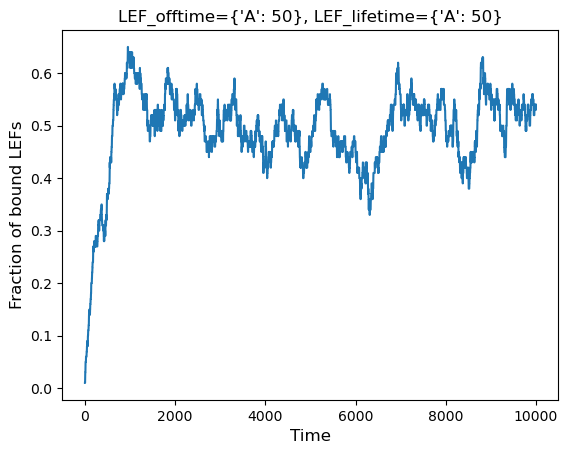

In [9]:
plt.plot(frac_bound_LEFs)

plt.title('LEF_offtime=%s, LEF_lifetime=%s' % (paramdict['LEF_offtime'], 
                                               paramdict['LEF_lifetime']))
          
plt.xlabel('Time', fontsize=12)
plt.ylabel('Fraction of bound LEFs', fontsize=12)

plt.show()

# Kymograph Analysis

In [10]:
def map_from_lefs(dset, sites_per_replica):
    
    ll = np.mod(dset, sites_per_replica)
    ll = ll[ll[:,1] > ll[:,0]]
    
    lmap = np.histogram2d(ll[:,0], ll[:,1], np.arange(sites_per_replica))[0]
    
    return (lmap + lmap.T)

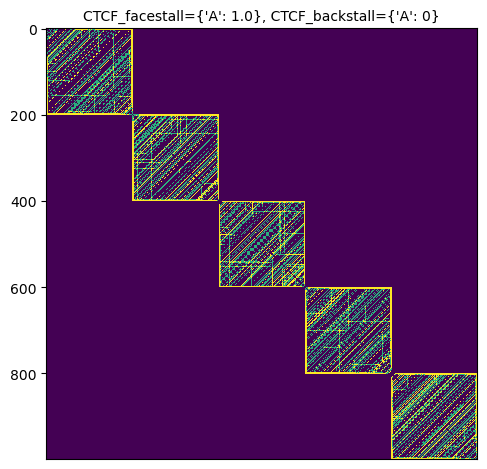

In [11]:
kymograph = map_from_lefs(hist, sites_per_replica)
                    
plt.matshow(np.log10(kymograph+1),vmax=1.5/(np.sqrt(paramdict['sites_per_monomer'])), fignum=False) 
            
plt.title('CTCF_facestall=%s, CTCF_backstall=%s' % (paramdict['CTCF_facestall'],
                                                    paramdict['CTCF_backstall']),
          fontsize=10)

plt.xticks([])
plt.yticks(fontsize=10)
            
plt.tight_layout()
plt.show()                       


# Adding non-homogeneous CTCF boundaries

In [12]:
# Let's make some strong and weak CTCF regions
type_list = ['strong_CTCF', 'weak_CTCF']

site_types[:sites_per_replica//2] = type_list.index('strong_CTCF')
site_types[sites_per_replica//2:] = type_list.index('weak_CTCF')

In [13]:
paramdict_nonuniform = {
    "CTCF_facestall": {
        "strong_CTCF": 1,
        "weak_CTCF": 0.5
    },
    "CTCF_backstall": {
        "strong_CTCF": 0,
        "weak_CTCF": 0
    },
    "CTCF_offtime": {
        "strong_CTCF": 0.1,
        "weak_CTCF": 0.1
    },
    "CTCF_lifetime": {
        "strong_CTCF": 10.,
        "weak_CTCF": 10.
    },
    "LEF_offtime": {
        "strong_CTCF": 0.1,
        "weak_CTCF": 0.1
    },
    "LEF_lifetime": {
        "strong_CTCF": 50,
        "weak_CTCF": 50
    },
    "LEF_stalled_lifetime": {
        "strong_CTCF": 50,
        "weak_CTCF": 50
    },
    "LEF_pause": {
        "strong_CTCF": 0,
        "weak_CTCF": 0
    },
    'LEF_separation': 10,
    'sites_per_monomer': 10,
    'monomers_per_replica': 100,
    'number_of_replica': 10,
    'steps': 1000,
    'velocity_multiplier': 1
}


In [14]:
CTCF_facestall = paramdict_nonuniform['CTCF_facestall']

print(CTCF_facestall['strong_CTCF'], CTCF_facestall['weak_CTCF'])

1 0.5


In [15]:
LEF_trans = translocator.make_translocator(LEFTranslocatorDynamicBoundary.LEFTranslocatorDynamicBoundary, 
                                           type_list,
                                           site_types,
                                           CTCF_left_positions,
                                           CTCF_right_positions, 
                                           **paramdict_nonuniform)

In [16]:
trajectory_length = paramdict_nonuniform['steps'] * paramdict_nonuniform['sites_per_monomer']

hist = []
frac_bound_LEFs = np.zeros(trajectory_length)

for i in range(trajectory_length):
    LEF_trans.step()

    bound_LEF_positions = translocator.get_bound_LEFs(LEF_trans)
    frac_bound_LEFs[i] = len(bound_LEF_positions) / float(LEF_trans.numLEF)

    hist.extend(bound_LEF_positions)

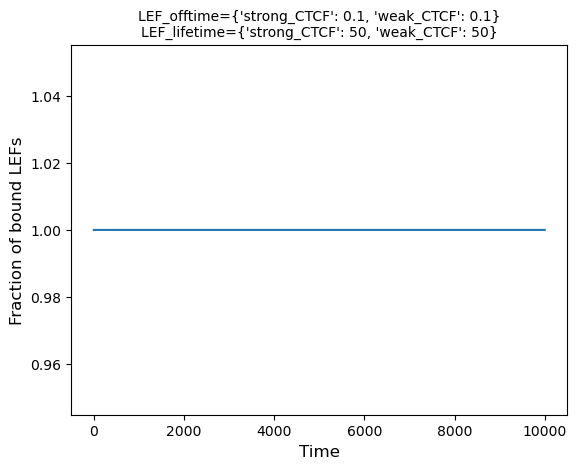

In [17]:
plt.plot(frac_bound_LEFs)

plt.title('LEF_offtime=%s\nLEF_lifetime=%s' % (paramdict_nonuniform['LEF_offtime'], 
                                               paramdict_nonuniform['LEF_lifetime']),
          fontsize=10)
          
plt.xlabel('Time', fontsize=12)
plt.ylabel('Fraction of bound LEFs', fontsize=12)

plt.show()

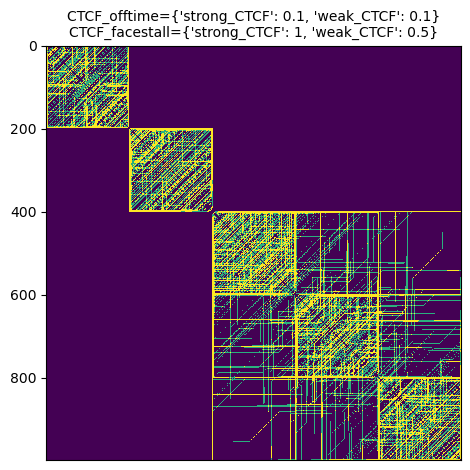

In [18]:
kymograph = map_from_lefs(hist, sites_per_replica)
                    
plt.matshow(np.log10(kymograph+1),vmax=1.5/(np.sqrt(paramdict_nonuniform['sites_per_monomer'])), fignum=False) 
                    
plt.title('CTCF_offtime=%s\nCTCF_facestall=%s' % (paramdict_nonuniform['CTCF_offtime'],
                                                  paramdict_nonuniform['CTCF_facestall']),
          fontsize=10)

plt.xticks([])
plt.yticks(fontsize=10)
            
plt.tight_layout()
plt.show()                       
                

In [19]:
# Or, alternatively, a region with higher CTCF offtime
paramdict_nonuniform['CTCF_facestall'] = {"strong_CTCF": 1, "weak_CTCF": 1}
paramdict_nonuniform['CTCF_offtime'] = {"strong_CTCF": 0.1, "weak_CTCF": 1}

In [20]:
LEF_trans = translocator.make_translocator(LEFTranslocatorDynamicBoundary.LEFTranslocatorDynamicBoundary, 
                                           type_list,
                                           site_types,
                                           CTCF_left_positions,
                                           CTCF_right_positions, 
                                           **paramdict_nonuniform)

In [21]:
trajectory_length = paramdict_nonuniform['steps'] * paramdict_nonuniform['sites_per_monomer']
hist = []

for _ in range(trajectory_length):
    LEF_trans.step()

    bound_LEF_positions = translocator.get_bound_LEFs(LEF_trans)

    hist.extend(bound_LEF_positions)

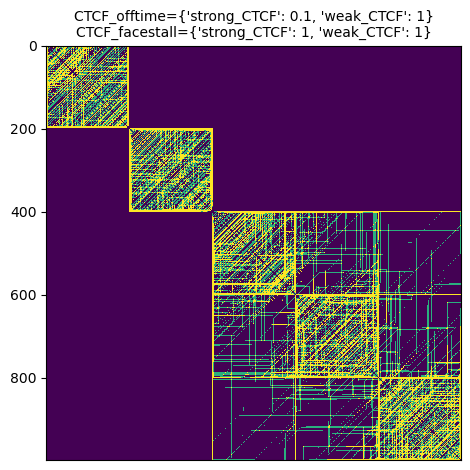

In [22]:
kymograph = map_from_lefs(hist, sites_per_replica)
                    
plt.matshow(np.log10(kymograph+1),vmax=1.5/(np.sqrt(paramdict_nonuniform['sites_per_monomer'])), fignum=False) 
                    
plt.title('CTCF_offtime=%s\nCTCF_facestall=%s' % (paramdict_nonuniform['CTCF_offtime'],
                                                  paramdict_nonuniform['CTCF_facestall']),
          fontsize=10)

plt.xticks([])
plt.yticks(fontsize=10)
            
plt.tight_layout()
plt.show()                       
                